In [ ]:
!pip show openai

Name: openai
Version: 0.28.1
Summary: Python client library for the OpenAI API
Home-page: https://github.com/openai/openai-python
Author: OpenAI
Author-email: support@openai.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, requests, tqdm
Required-by: llmx


In [ ]:
# Make sure the OpenAI library is installed
%pip install openai==0.28.1

# We'll need to install the Chroma client
%pip install chromadb

# Install numpy for data manipulation
%pip install numpy

In [ ]:
import pandas as pd
import openai
import chromadb
import numpy as np

In [ ]:
df = pd.read_csv('tableExport.csv')

In [ ]:
df.head(2)

,Name,Platform,DOIs,Pub Dates,Citations,Code,Description,License,Categories,Assembly,Alignment,UMIs
0,acorde,R,"10.1038/s41467-022-29497-w, 10.1101/2021.05.07...","2022-04-05, NA",6,https://github.com/ConesaLab/acorde,Isoform co-usage networks from single-cell RNA...,GPL-3.0,"Alternative Splicing, Differential Expression,...",False,False,False
1,ACTINN,Python,"10.1093/bioinformatics/btz592, 10.1101/532093","2019-07-29, NA",107,https://github.com/mafeiyang/ACTINN,ACTINN (Automated Cell Type Identification usi...,GPL-3.0,Classification,False,False,False


In [ ]:
chroma_client = chromadb.EphemeralClient() # Equivalent to chromadb.Client(), ephemeral.
# Uncomment for persistent client
# chroma_client = chromadb.PersistentClient()

In [ ]:
EMBEDDING_MODEL = "text-embedding-ada-002"
# change this to biotech specialised model later

In [ ]:
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

from google.colab import userdata

if userdata.get('OPENAI_API_KEY') is not None:
    openai.api_key = userdata.get('OPENAI_API_KEY')
    print ("OPENAI_API_KEY is ready")
else:
    print ("OPENAI_API_KEY environment variable not found")


embedding_function = OpenAIEmbeddingFunction(api_key=userdata.get('OPENAI_API_KEY'), model_name=EMBEDDING_MODEL)

OPENAI_API_KEY is ready


In [ ]:
scrnatools_description_collection = chroma_client.create_collection(name='scRNA_Tools', embedding_function=embedding_function)

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken
def num_tokens_from_string(string: str, model_name: str = "gpt-3.5-turbo") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
def make_desc(row):
    # Example function using row 'A' and 'B'
    return 'Platform: ' + row['Platform'] + \
            '\n Description: ' + row['Description'] + \
            '\n Categories: ' + row['Categories']

df['extented_desc'] = df.apply(make_desc, axis=1)

In [ ]:
assert df.isna().sum()['extented_desc'] == 0 # check for nans in desc to make embedding collection

In [ ]:
df['tokens_in_ext_desc'] = df['extented_desc'].apply(num_tokens_from_string)

<Axes: >

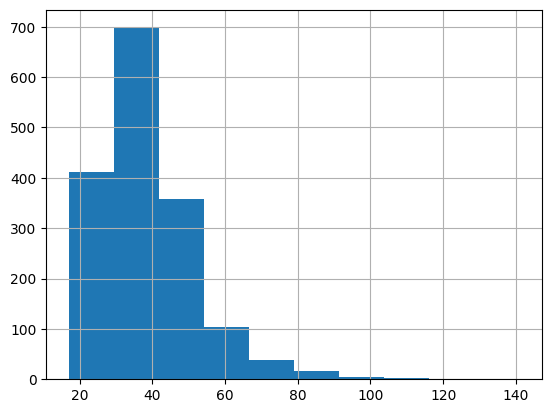

In [ ]:
df['tokens_in_ext_desc'].hist()

In [ ]:
assert df['tokens_in_ext_desc'].sum() < 100000
# as if Nov 7 2023 allshort  descriptions of tools is jsut 68K tokens, so
# no need for embed db truly speaking, can also just make claude calls every time need to pick a tool

In [ ]:
assert df.Name.nunique() == df.shape[0]

In [ ]:
# Add the content vectors
scrnatools_description_collection.add(
    documents = list(df['extented_desc']),
    metadatas = df.drop(['extented_desc'], axis = 1).to_dict(orient='records'),
    ids = list(df.Name)
)

In [ ]:
def query_collection(collection, query, max_results, dataframe):
    results = collection.query(query_texts=query, n_results=max_results, include=['distances'])
    df = pd.DataFrame({
                'id':results['ids'][0],
                'score':results['distances'][0],
                'content': dataframe[dataframe.Name.isin(results['ids'][0])]['extented_desc'],
                'platform': dataframe[dataframe.Name.isin(results['ids'][0])]['Platform'],
                })

    return df

In [ ]:
query_collection(scrnatools_description_collection, 'quality controll python', 5, df)

,id,score,content,platform
20,AmbientContaminationMetrics,0.365305,Platform: Python\n Description: Quantification...,Python
305,ddqc,0.395694,Platform: Python/R\n Description: Biology-cent...,Python/R
390,SinQC,0.401830,Platform: Python\n Description: Quality contro...,Python
451,fba,0.412007,Platform: Python\n Description: A flexible and...,Python
1427,DrSeq2,0.416318,Platform: R/Python\n Description: A Method and...,R/Python
